In this notebook, I use the Light Gradient-Boosting Machine library to model factors in flood-risks in San Francisco (dataset from SF Gov). I use permutation importance (which is model-agnostic) to find the few most important features. Then, I use the top few features to create a neural network that predicts flood risk using pytorch. I compare this to the LightGBM's model with full features, and find (unsurprisingly, perhaps), that my model is less effective at predicting flood risk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Load dataset

In [2]:
data = pd.read_csv("https://data.sfgov.org/resource/cne3-h93g.csv")
df = pd.DataFrame(data)

In [3]:
#Check if CUDA is available - AKA make sure another session is not open
torch.cuda.is_available()

True

In [4]:
gpu = torch.device("cuda")
cpu = torch.device("cpu")

In [5]:
df.columns #Check features

Index(['census_blockgroup', 'children', 'children_wnullvalues', 'elderly',
       'elderly_wnullvalues', 'nonwhite', 'nonwhite_wnullvalues', 'poverty',
       'poverty_wnullvalues', 'education', 'education_wnullvalues', 'english',
       'english_wnullvalues', 'elevation', 'sealevelrise', 'precipitation',
       'diabetes', 'mentalhealth', 'asthma', 'disability',
       'disability_wnullvalues', 'housingquality', 'homeless', 'livalone',
       'livalone_wnullvalues', 'floodhealthindex',
       'floodhealthindex_quintiles'],
      dtype='object')

In [6]:
df.shape

(578, 27)

Hypothesis: Areas with higher poverty and fewer white people have worse flood risks in the bay area

Next steps: test different features

We will use lightGBM (light gradient-boosting machine)

# Train lightgbm model

lightGBM with 20 leaves

In [7]:
from sklearn.model_selection import train_test_split #To split data into learning and testing data
# Prepare Data
nan_cols = ['disability_wnullvalues','livalone_wnullvalues','education_wnullvalues','poverty_wnullvalues','elderly_wnullvalues','nonwhite_wnullvalues','english_wnullvalues','children_wnullvalues']
X = df.drop(columns=['floodhealthindex','floodhealthindex_quintiles'] + nan_cols) #New dataframe of X variables
y = df['floodhealthindex'] #Series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# LightGBM Model Setup
lgb_model = lgb.LGBMRegressor(
    num_leaves=20,
    min_data_in_leaf=20,
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4
)

#Fit model
lgb_model.fit(X_train,y_train)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2149
[LightGBM] [Info] Number of data points in the train set: 462, number of used features: 17
[LightGBM] [Info] Start training from score 49.498748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(learning_rate=0.05, max_depth=4, min_data_in_leaf=20,
              n_estimators=200, num_leaves=20)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Mean Squared Error: 5.037380680115695
R² score: 0.9678928799705554


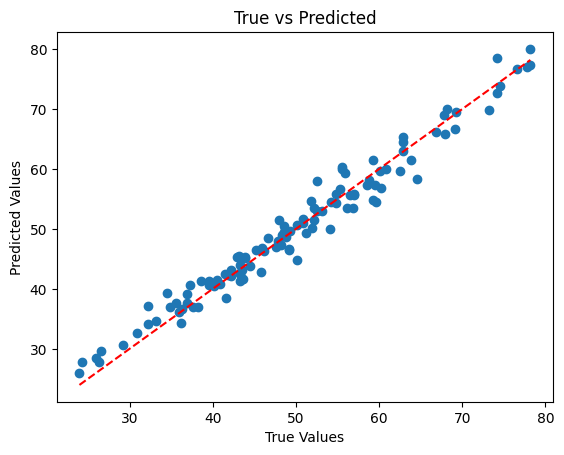

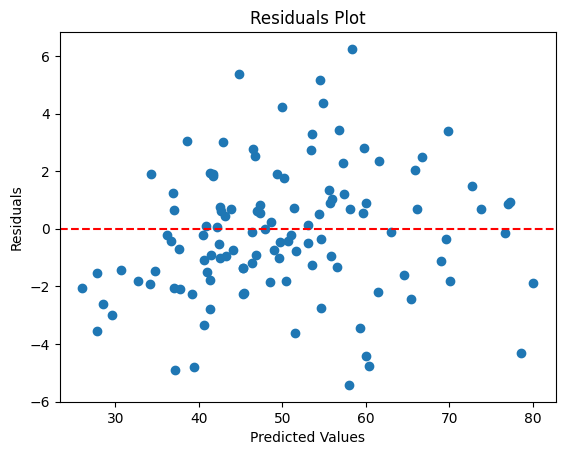

In [8]:
#Testing lightgbm model
from sklearn.metrics import mean_squared_error, r2_score
#Predict on test set
y_pred = lgb_model.predict(X_test)

#Calculate MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

#Calculate R² score (optional)
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2}")

#Visualising results
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted')
plt.show()

#Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

#Feature Importance with  Permutation Importance

In [9]:
from sklearn.inspection import permutation_importance

#Calculate permutation importance
imp_features = permutation_importance(lgb_model, X_test, y_test, n_repeats=10, random_state=42)

#Create dataframe to display feature importance
features_df = pd.DataFrame({
    'Feature' : X.columns,
    'Importance' : imp_features.importances_mean #Extract importances
}).sort_values(by='Importance', ascending=False)

features_df



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

,Feature,Importance
7,elevation,0.179410
9,precipitation,0.170397
4,poverty,0.101879
11,mentalhealth,0.087040
13,disability,0.043546
15,homeless,0.037571
14,housingquality,0.024912
1,children,0.022797
5,education,0.020281
8,sealevelrise,0.020014


This shows that among the most important factors for flood-risk are **elevation (understandably), poverty, precipitation, disability, mental health and homelessness**

Skin colour, diabetes risk and census group rank as least important.

*This goes against my hypothesis - poverty is a key factor, skin colour/ethnicity is not.*

#Training Pytorch Model

In [10]:
#Select specified features (eg top 6)
top_features = features_df['Feature'].head(6).tolist()

# Create a new dataframe with selected features
X_selected = X[top_features]

#Split data again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [11]:
y_train.shape, X_train.shape #Double check shape of training data

((462,), (462, 6))

In [26]:
#Define neural network as function
import torch.nn as nn
class NonLinearNN(torch.nn.Module):
    def __init__(self, input_size):
        super(NonLinearNN, self).__init__()
        # Linear layer followed by a non-linear activation (ReLU)

        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)# Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)  # Non-linear activation
        x = self.fc2(x)
        x = self.relu(x)  # Non-linear activation
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

# Input size of features
input_size = X_train.shape[1]

# Call model and use GPU
model = NonLinearNN(input_size).cuda()

# Define loss function and optimizer
criterion = torch.nn.MSELoss() #MSE
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #Adam backprop

# Example input data (move to GPU if available)
X_sel_tensor = torch.tensor(X_train.values).float().cuda()
y_tensor = torch.tensor(y_train.values).float().view(-1, 1).cuda()



In [16]:
X_sel_tensor.shape

torch.Size([462, 6])

In [27]:
#Train Model

# Training loop
model.train()
num_epochs = 500
losses = []
for i in range(num_epochs):
    optimizer.zero_grad() #Reset grads to zero to prevent stacking errors
    outputs = model(X_sel_tensor)  # Forward pass
    loss = criterion(outputs, y_tensor)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    losses += [loss.item()]

In [28]:
losses

[2503.17919921875,
 1964.5975341796875,
 1547.6402587890625,
 1354.0146484375,
 1496.002685546875,
 1406.61572265625,
 1222.53466796875,
 1058.15576171875,
 966.8783569335938,
 887.724365234375,
 775.402587890625,
 645.5503540039062,
 560.2442626953125,
 529.999755859375,
 475.510498046875,
 447.82086181640625,
 488.79638671875,
 534.1142578125,
 533.9505615234375,
 503.3017578125,
 477.77752685546875,
 451.302490234375,
 412.80841064453125,
 389.6716613769531,
 390.09686279296875,
 397.8336181640625,
 398.7470703125,
 396.3440856933594,
 397.1947937011719,
 397.4039306640625,
 389.55975341796875,
 375.8237609863281,
 363.6387939453125,
 355.85443115234375,
 349.222412109375,
 342.0242919921875,
 338.7665100097656,
 340.2511291503906,
 341.86883544921875,
 339.2861328125,
 335.18701171875,
 330.7646789550781,
 323.7764587402344,
 316.0163879394531,
 312.1437683105469,
 308.5439758300781,
 305.17071533203125,
 303.3852844238281,
 300.4480895996094,
 296.4128112792969,
 293.8784484863281

27.955078125

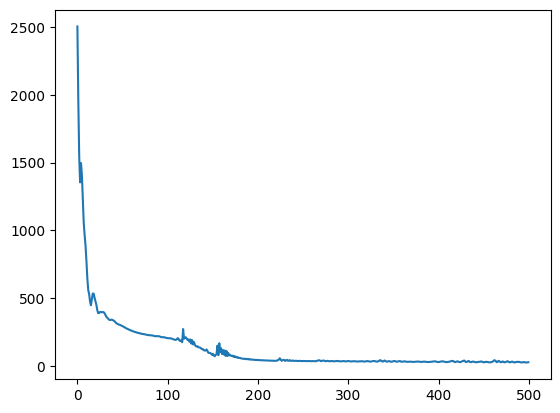

In [29]:
plt.plot(losses)
losses[-1] #This is still quite high

# Evaluating Pytorch Model

In [30]:
model.eval()
X_test_tensor = torch.tensor(X_test.values).cuda().float()

In [31]:
with torch.no_grad():  # Disable gradient computation for inference
    y_pred = model(X_test_tensor).cuda()  # Get predictions for the test data

# Optionally, compute metrics like MSE, RMSE, etc.
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred.cpu().numpy())
print(f"Mean Squared Error on Test Set: {mse:.4f}")

Mean Squared Error on Test Set: 35.5792


In [22]:
y_test

,floodhealthindex
257,49.9264
574,22.6198
485,36.5597
101,63.2594
566,26.2998
...,...
346,44.5197
182,55.2595
442,38.9663
75,66.4927


In [23]:
#Calculate residuals
y_pred_vals = y_pred.cpu().numpy().flatten().shape
residuals = y_test.values - y_pred_vals

In [24]:
#Check shape
residuals.shape,y_test.shape,y_pred.cpu().numpy().flatten().shape

((116,), (116,), (116,))

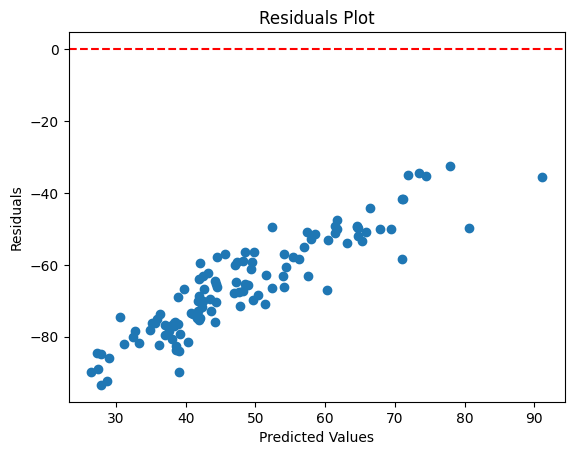

In [32]:
#Plot residuals
plt.scatter(y_pred.cpu().numpy(), residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontal line at 0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

So we get consistently bad residuals for our pytorch model, and a very high MSE. However, the MSE is down to around 30 from roughly 330 (from just one additional layer - it was 330 when I had 3 layers, and 30 now I have 4. Interestingly, it seems to stabilise around 30 for 5/6 layers), so that is an improvement.

I don't know why this is. I am looking forward to finding out why when I take a machine learning course in January 2025!